In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/Bone-Age-Assessment"

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/Bone-Age-Assessment

/content/gdrive/My Drive/Colab Notebooks/Bone-Age-Assessment


In [ ]:
# !kaggle datasets download -d kmader/rsna-bone-age

100% 9.28G/9.29G [02:29<00:00, 23.1MB/s]
100% 9.29G/9.29G [02:29<00:00, 66.5MB/s]


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
train_df = pd.read_csv('boneage-training-dataset.csv')
test_df = pd.read_csv('boneage-test-dataset.csv')
# train_df.head()

train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')

In [ ]:
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0)
mean_bone_age = train_df['boneage'].mean()  
std_bone_age = train_df['boneage'].std()
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

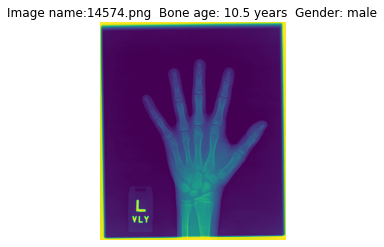

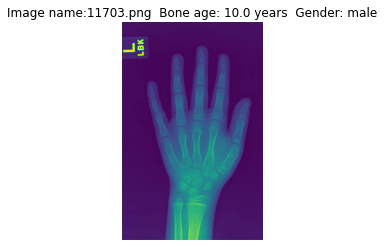

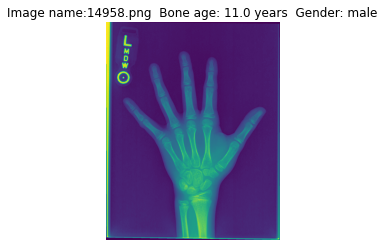

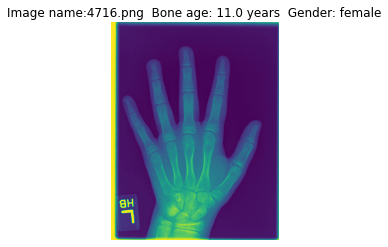

In [ ]:
import matplotlib.image as mpimg
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(4).values:
    img = mpimg.imread('boneage-training-dataset/boneage-training-dataset/'+ filename)
    plt.imshow(img)
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender))
    plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

img_size = 256

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train, directory = 'boneage-training-dataset/boneage-training-dataset',
    x_col= 'id', y_col= 'bone_age_z', batch_size = 32, seed = 42,
    shuffle = True, class_mode= 'raw', flip_vertical = True,
    color_mode = 'rgb', target_size = (img_size, img_size))

validation_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid, directory = 'boneage-training-dataset/boneage-training-dataset',
    x_col= 'id', y_col= 'bone_age_z', batch_size = 32, seed = 42,
    shuffle = True, class_mode= 'raw', flip_vertical = True,
    color_mode = 'rgb', target_size = (img_size, img_size))

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = 'boneage-test-dataset/boneage-test-dataset',
    shuffle = False, 
    class_mode = None,
    color_mode = 'rgb',
    target_size = (256,256))

Found 10088 validated image filenames.
Found 2523 validated image filenames.
Found 0 images belonging to 0 classes.


In [ ]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            dataframe = df_valid, directory = 'boneage-training-dataset/boneage-training-dataset',
                            x_col = 'id', y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'raw'
                            )) 

Found 2523 validated image filenames.


In [ ]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
  return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age))

In [ ]:
from keras import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten

model1 = tf.keras.applications.xception.Xception(
        input_shape=(img_size, img_size, 3), include_top = False, weights = 'imagenet'
    )
model1.trainable = True
model2 = Sequential()
model2.add(model1)
model2.add(GlobalMaxPooling2D())
model2.add(Flatten())
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(loss='mse', optimizer='adam', metrics=[mae_in_months])
model2.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
# early_stopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience= 5,
#                               verbose=0, mode='auto')

# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# #reduce lr on plateau
# red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [early_stopping,mc, red_lr_plat]

# history = model2.fit_generator(train_generator, steps_per_epoch=300, validation_data=validation_generator, validation_steps=1, 
#                                epochs=50, callbacks=callbacks)

79/79 [==============================] - 30s 379ms/step


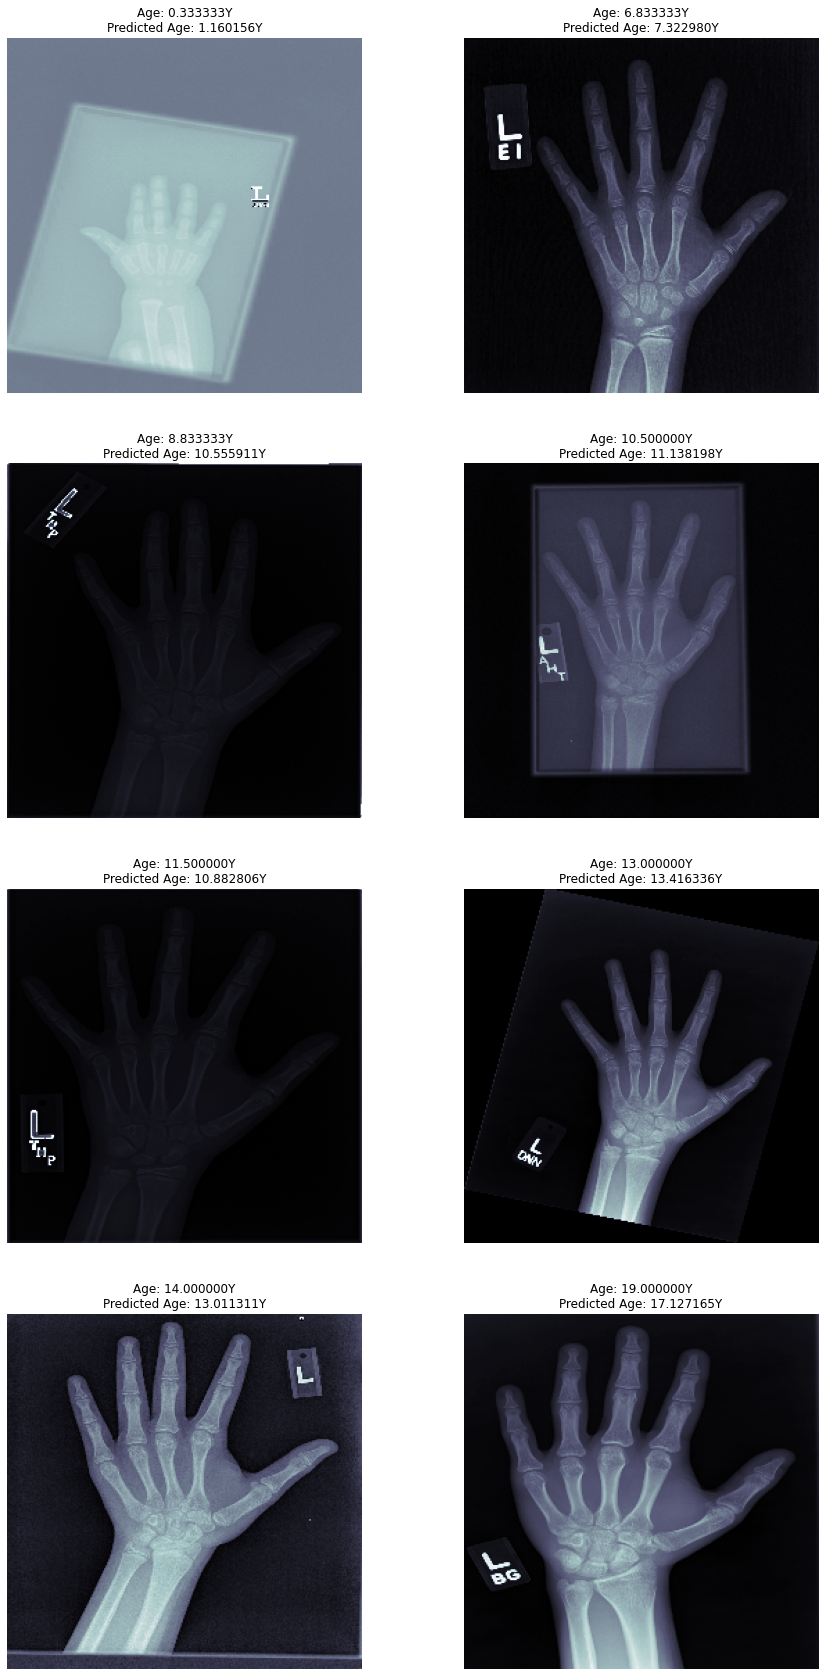

In [ ]:
model2.load_weights('best_model.h5')
pred = mean_bone_age + std_bone_age*(model2.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 1080)

In [ ]:
test_generator.reset()
y_pred = model2.predict_generator(test_generator)
predicted = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predicted)
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions": predicted_months})
results.to_csv("results.csv",index=False)